In [4]:
# Clean the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

In [7]:
X_train = pd.read_csv("x_train_final.csv")
X_train = X_train[["train", "gare", "date", "arret", "p2q0", "p3q0", "p4q0", "p0q2", "p0q3", "p0q4"]]
y_train = pd.read_csv("y_train_final_j5KGWWK.csv")
y_train = y_train[["p0q0"]]

# Clustering x_train Based on Selected Features

In [11]:
df = X_train
df = df.drop_duplicates()

In [13]:
clustering_features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
X = df[clustering_features].copy()
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Set number of clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = cluster_labels

In [17]:
print("Cluster element counts:")
print(df['cluster'].value_counts())

Cluster element counts:
cluster
0    666215
1      1049
Name: count, dtype: int64


In [19]:
# We'll reduce the clustering features to two principal components so that we can visualize the clusters.

# %% [code]
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_scaled)
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

# Print explained variance to see how much variance is captured
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

Explained variance ratio (PC1, PC2): [0.28560967 0.19489716 0.17290671 0.1544471  0.13345294 0.05868641]


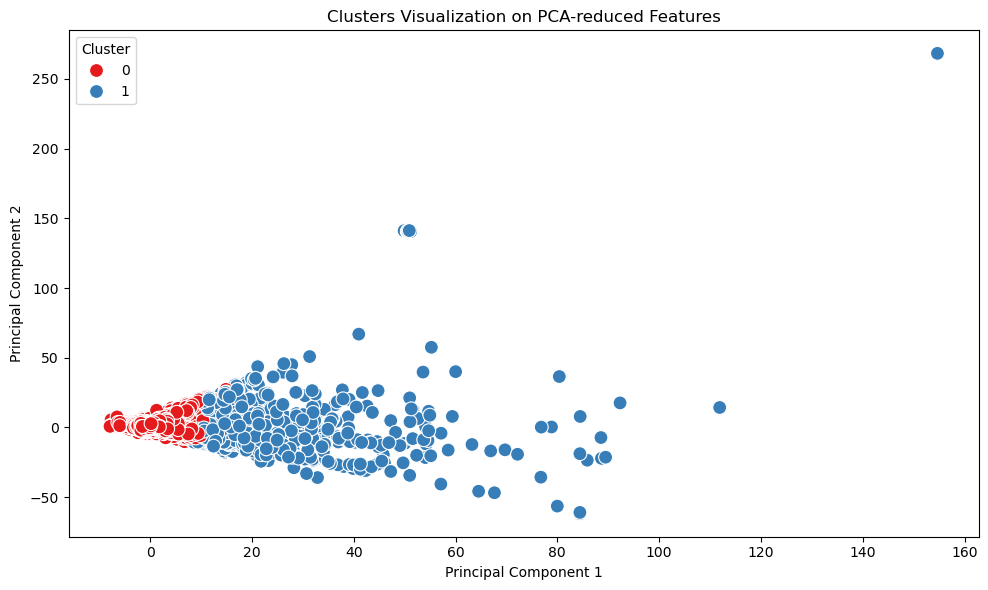

In [21]:
# Plot clusters based on PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_one', y='pca_two', hue='cluster', palette='Set1', s=100)
plt.title('Clusters Visualization on PCA-reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

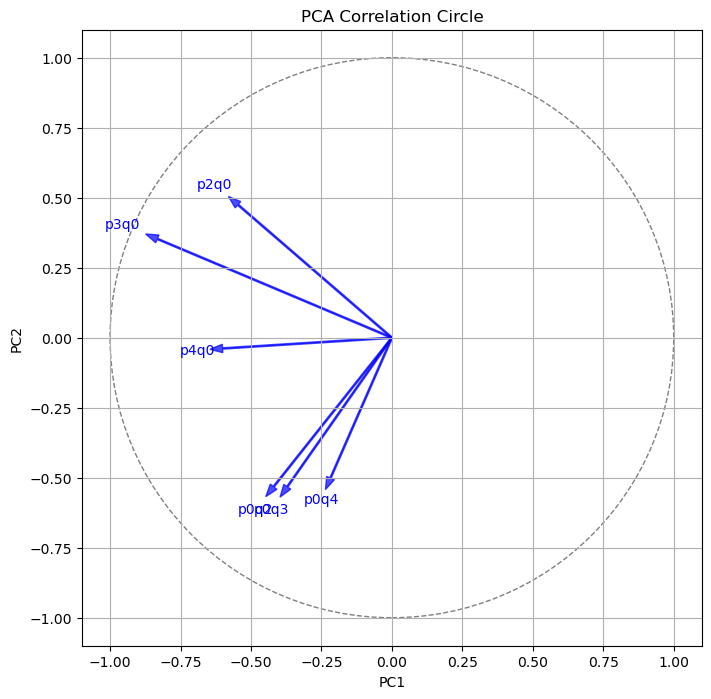

In [22]:
# Create a PCA correlation circle for the original clustering features.
# This plot shows the loadings (contributions) of each feature on the first two principal components.

features = clustering_features
correlations = np.zeros((2, len(features)))

for j in range(len(features)):
    correlations[0, j] = pca.components_[0, j] * np.sqrt(pca.explained_variance_[0])
    correlations[1, j] = pca.components_[1, j] * np.sqrt(pca.explained_variance_[1])

plt.figure(figsize=(8, 8))
# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Plot each feature as an arrow from the origin
for i, feature in enumerate(features):
    plt.arrow(0, 0, correlations[0, i], correlations[1, i], color='b',
              width=0.005, head_width=0.03, alpha=0.7)
    plt.text(correlations[0, i] * 1.15, correlations[1, i] * 1.15, feature,
             color='b', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Correlation Circle')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()


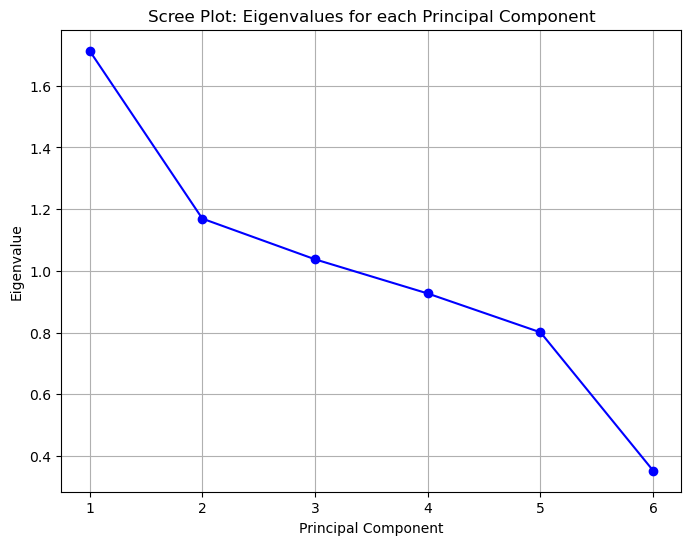

In [23]:
# Compute PCA with all components to inspect eigenvalues
pca_full = PCA()
pca_full.fit(X_scaled)

# Retrieve the eigenvalues
eigenvalues = pca_full.explained_variance_

# Plot the eigenvalues (Scree Plot) to apply the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot: Eigenvalues for each Principal Component')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()


Based on the above graphs, we see that only one component can help us segregate the values, therefore wee that there may be 1 outlier in the population

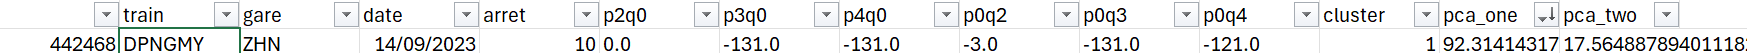

Let's dive a bit more using an unsupervised classification

Initialization complete
Iteration 0, inertia 695818.940372961.
Iteration 1, inertia 690627.4599495877.
Iteration 2, inertia 690502.3053883375.
Iteration 3, inertia 690386.7429070352.
Iteration 4, inertia 690333.6608805698.
Iteration 5, inertia 690283.5525787992.
Iteration 6, inertia 690256.1753051167.
Iteration 7, inertia 690235.2002299718.
Iteration 8, inertia 690207.7453962216.
Iteration 9, inertia 690173.0645532188.
Iteration 10, inertia 690143.8312182755.
Iteration 11, inertia 690114.5676521208.
Iteration 12, inertia 690083.4570580785.
Iteration 13, inertia 690074.2688151663.
Iteration 14, inertia 690067.2834036091.
Iteration 15, inertia 690061.2110195919.
Iteration 16, inertia 690059.4870494445.
Converged at iteration 16: strict convergence.
Cluster distribution:
 0    666236
1      1028
Name: count, dtype: int64
Assumed outlier cluster: 1


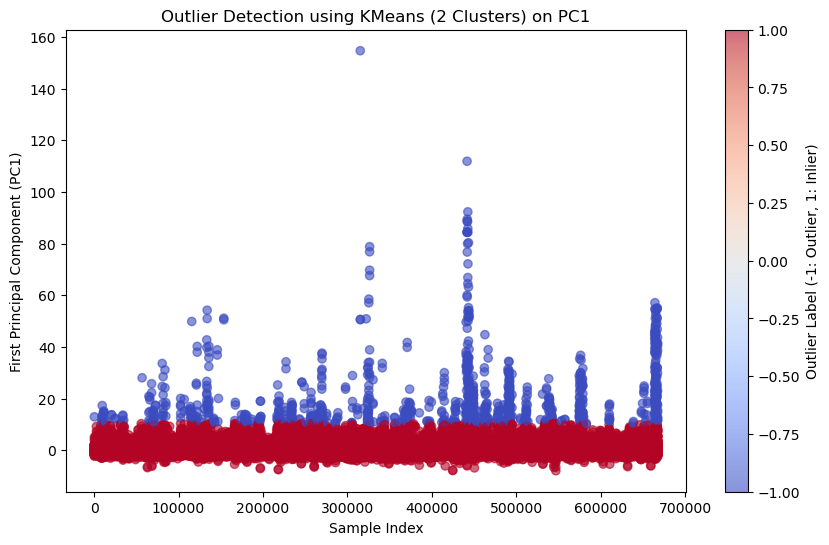

In [37]:
# Extract the first principal component from the PCA results and reshape to a 2D array
pc1 = df["pca_one"].to_numpy().reshape(-1, 1)

# Using only PC1 for clustering (reshaped already as pc1 from previous blocks)
# Apply KMeans with 2 clusters on PC1 and enable verbose output.
kmeans_2 = KMeans(n_clusters=2, verbose=1)
clusters = kmeans_2.fit_predict(pc1)

# Display cluster distribution
cluster_counts = pd.Series(clusters).value_counts()
print("Cluster distribution:\n", cluster_counts)

# Heuristically, we assume the minority cluster corresponds to outliers.
# Identify the cluster with the fewest members.
outlier_cluster = cluster_counts.idxmin()
print("Assumed outlier cluster:", outlier_cluster)

# Create outlier labels: assign -1 for outliers and 1 for inliers.
clusters_outlier_label = np.where(clusters == outlier_cluster, -1, 1)

# Save the outlier labels into the dataframe
df['cluster_outlier'] = clusters_outlier_label

# Plot PC1 with outlier detection via KMeans classification
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pc1)), pc1, c=clusters_outlier_label, cmap='coolwarm', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("First Principal Component (PC1)")
plt.title("Outlier Detection using KMeans (2 Clusters) on PC1")
plt.colorbar(label="Outlier Label (-1: Outlier, 1: Inlier)")
plt.show()
